In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy import *
from astropy.table import Table


%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 200             #72 
colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [263]:
M = 1.16
P = 628.
year = 365.25
aearth = 1.
rsun = 6.957e8
au = 149597870700 # m

print rsun/au

0.00465046726096


In [264]:
const = aearth**3 / year**2

In [265]:
a = (P**2 * const)**(1/3.)
print a

1.43520171971


In [266]:
R = M**0.8
print R

1.12607260049


In [267]:
def L(M):
    logl = 4.328*np.log(M) -0.002
    return np.exp(logl)
    
print L(M)

1.89716711637


In [268]:
def teffpred(L,R):
    return 5777.*(L/R**2.)**0.25

print teffpred(L(M),R)

6389.18655302


In [269]:
def teq(Teff,Rstar,axis,f,A):
    '''Teff is star, R is stellar radius, a is semimajor axis, A is Bond albedo, f is the 
    geometric factor of reradiation'''
    
    return Teff*np.sqrt(Rstar*rsun/2./(axis*au))*(f*(1.-A))**0.25

In [270]:
tstar = teffpred(L(M),R)

In [271]:
tplan = teq(tstar,R,a,2.0,0.5)
print tplan

272.901290532


In [272]:
L(M)/(a**2)

0.92104255464806839

In [273]:
R

1.1260726004890476

In [274]:
## earth

Tearth = teq(5777,1.,1.,2.0,0.29)
print Tearth

304.093930109


In [275]:
tvenus = teq(5770,1.,0.72,1.0,0.6)
print tvenus

260.770140262


In [276]:
mas2rad = 1000*3600*180./np.pi

In [277]:
## today

giant_teff = 3934.

distance = 19.34 # pc
angular = 20.58e-3
print angular

linear = angular*distance*(au)/rsun



0.02058


In [278]:
tgiant = teq(giant_teff,linear,a,2.0,0.5)

In [279]:
tgiant

1464.9196508550642

## Now let's use MCMC to get uncertainties on these. We have uncertainties in mass and everthing else is derived from scaling relations.

In [280]:
nmass = 10000
masses = 1.16 + np.random.randn(nmass)*0.07

In [281]:
ells = L(masses)
arrs = masses**0.8

teffs = teffpred(ells,arrs)

In [282]:
const = aearth**3 / year**2

In [283]:
axes = (P**2 * const*masses)**(1/3.)

In [284]:
teqs = teq(teffs,arrs,axes,2.,0.29)


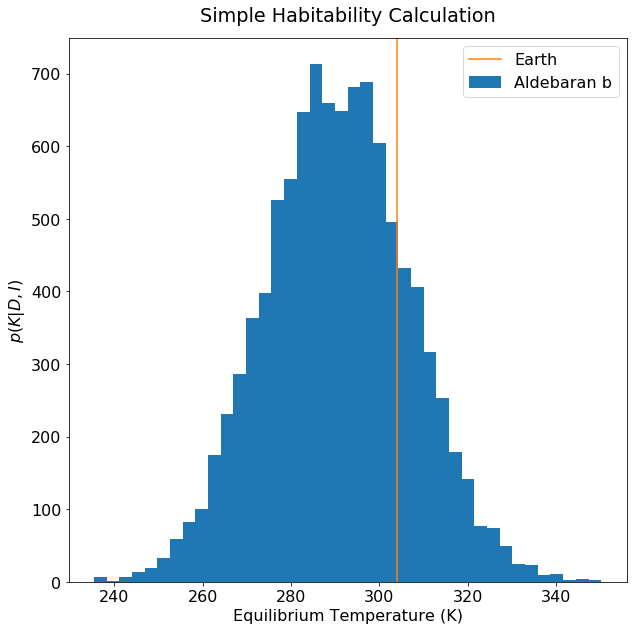

In [285]:
h = plt.hist(teqs,bins=40,label="Aldebaran b")
plt.axvline(Tearth,color=colours[1],label="Earth")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel(r"$p(K|D,I)$")
plt.legend()
plt.title('Simple Habitability Calculation',y=1.02)
plt.savefig('aldebaran_b_habitability.png')

In [286]:
print np.mean(teqs), np.std(teqs)

290.590554851 16.1982126448


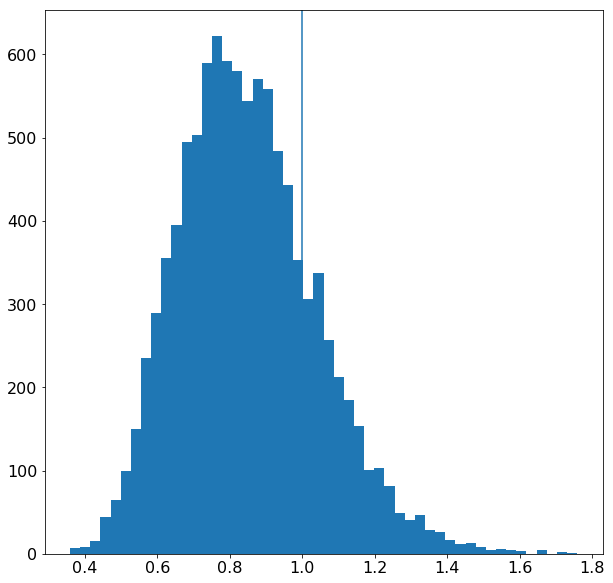

In [287]:
h = plt.hist(ells/axes**2.,bins=50)
plt.axvline(1.0)

In [288]:
print np.mean(ells/(axes**2.)), np.std(ells/(axes**2.))

0.849460531389 0.189633610418


In [289]:
print np.mean(ells), np.std(ells)

1.94831038184 0.515285366381


In [290]:
print np.mean(axes), np.std(axes)

1.5073809654 0.0306422439095


## Let's do this with proper stellar models

In [291]:
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

In [292]:
%%time
rad = mist.radius(M,6.,-0.3)

CPU times: user 10.5 s, sys: 5.06 s, total: 15.5 s
Wall time: 26.3 s


In [293]:
rad

2.4409202906989584

In [294]:
t = np.linspace(9.8,11.,1000)
t = np.log10(np.linspace(1e6,15e9,1000))
numaxes = mist.nu_max(1.,t,0.0)
radii = mist.radius(1.,t,0.0)

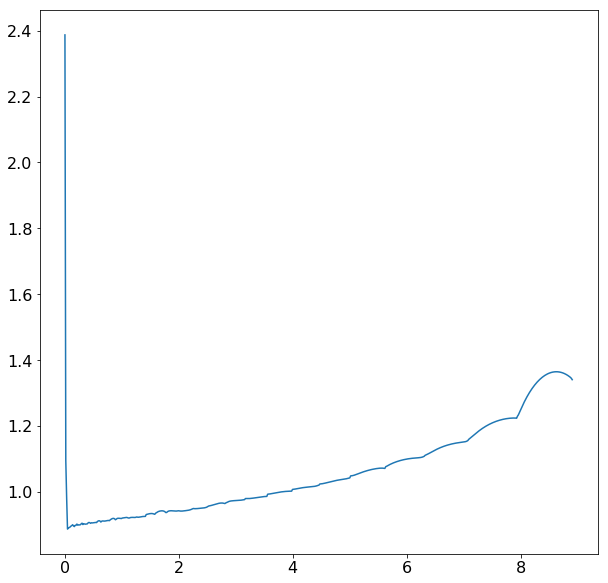

In [295]:
# plt.plot(t,numaxes)
plt.plot(10**t/1e9,radii)

In [310]:
t = np.log10(1.e9*np.linspace(0.2,7.,2000))

rr = mist.radius(M,t,-0.15)

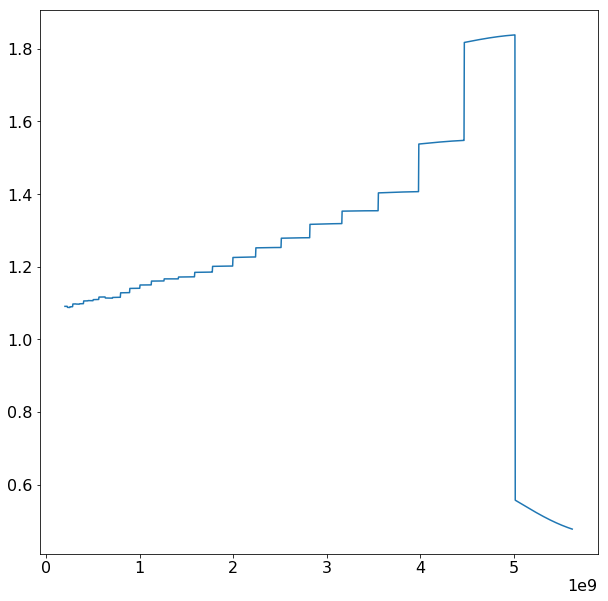

In [311]:
plt.plot(10**t,rr)

In [312]:
### ok now do aldebaran
fehs = -0.15 + 0.2*np.random.randn(nmass)
radii = mist.radius(masses,np.log10(2.e9),fehs)
logLs = mist.logL(masses,np.log10(2.e9),fehs)

In [313]:
ells2 = 10**logLs

In [314]:
ells2.shape

(10000,)

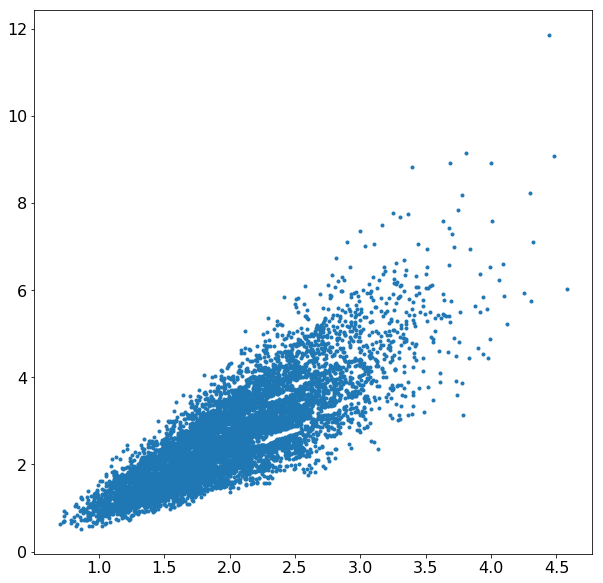

In [315]:
plt.plot(ells,ells2,'.')

In [323]:
times = np.linspace(0.5,4.5,10.)
means, stds = [], []
meanells, stdells = [], []

fehs = -0.15 + 0.2*np.random.randn(nmass)

for t in times:
    radii = mist.radius(masses,np.log10(t*1.e9),fehs)
    logLs = mist.logL(masses,np.log10(t*1.e9),fehs)
    ells2 = 10**logLs
    meanells.append(np.nanmean(ells2))
    stdells.append(np.nanstd(ells2))
    
    ratios = ells2/axes**2.
    ratios = ratios[np.isfinite(ratios)]
    
    means.append(np.nanmean(ratios))
    stds.append(np.nanstd(ratios))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [324]:
print means

[0.86739929417729333, 0.92928935261118395, 0.98654029329110138, 1.0734134253655006, 1.1610011651897008, 1.2313506999671395, 1.3834111650095633, 1.4649754753895752, 1.5459834482038453, 1.5506846301035599]


<Container object of 3 artists>

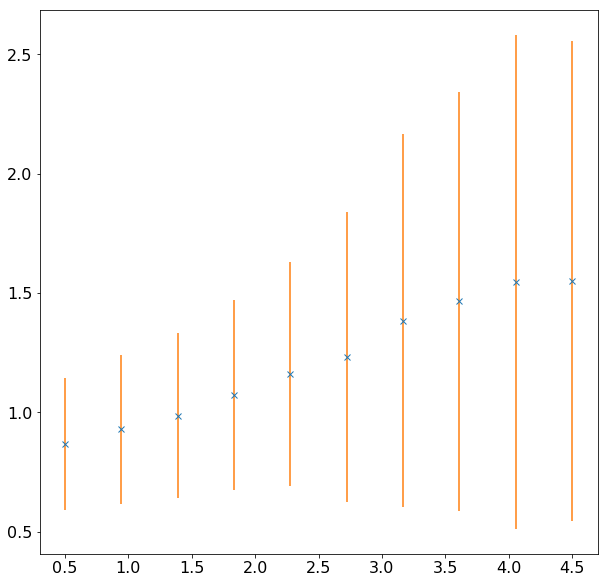

In [325]:
plt.plot(times,means,'x')
plt.errorbar(times,means,yerr=stds,linestyle='none')

<Container object of 3 artists>

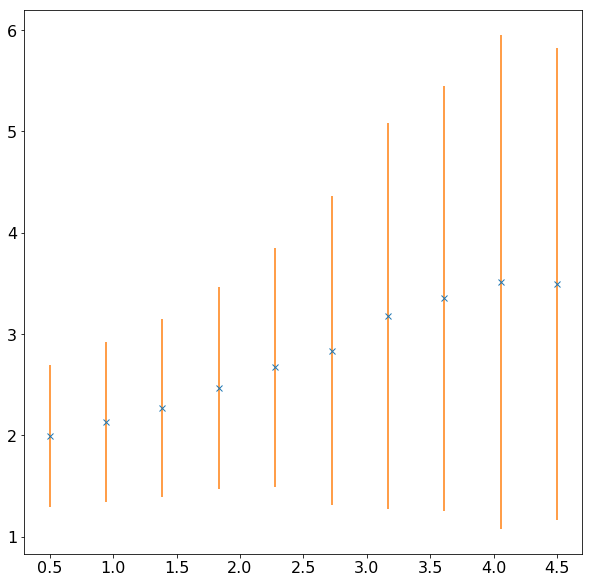

In [326]:
plt.plot(times,meanells,'x')
plt.errorbar(times,meanells,yerr=stdells,linestyle='none')

In [327]:
print meanells[0], stdells[0]
print meanells[-1], stdells[-1]

1.99211207818 0.703556509284
3.49257563287 2.33278016205


In [328]:
print means[0], stds[0]
print means[-1], stds[-1]

0.867399294177 0.275628677465
1.5506846301 1.00589622465


In [331]:
print axes.mean()
print axes.std()

1.5073809654
0.0306422439095


In [231]:
ratios.max()

3.23148814280351

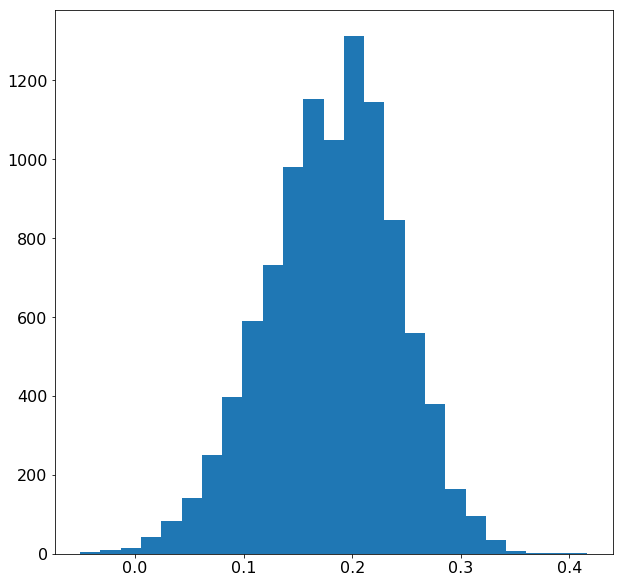

In [244]:
k = plt.hist(ratios,bins=25)
# plt.axvline(1.0,color=colours[1])

ValueError: max must be larger than min in range parameter.

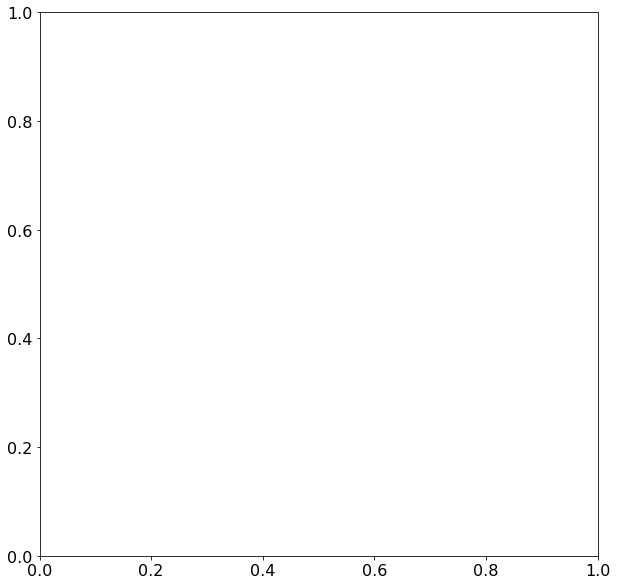

In [225]:
h = plt.hist(ells2/ells,bins=100)
print np.mean(ells2/ells), np.std(ells2/ells)

In [202]:
print np.mean(ells2/(axes**2.)), np.std(ells2/(axes**2.))

0.808335668439 0.145391648765


In [193]:
# arrs2 = mist.radius(masses,np.log10(2e9),-0.34)
arrs2 = mist.radius(masses,np.log10(1e9),-0.15)

In [194]:
teffs2 = teffpred(ells2,arrs2)

In [195]:
teqs = teq(teffs2,arrs2,axes,2.,0.29)


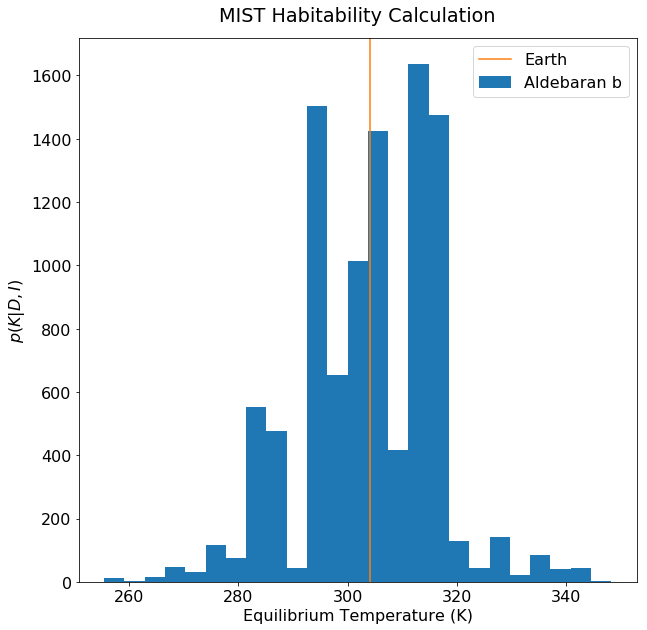

In [196]:
h = plt.hist(teqs,bins=25,label="Aldebaran b")
plt.axvline(Tearth,color=colours[1],label="Earth")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel(r"$p(K|D,I)$")
plt.legend()
plt.title('MIST Habitability Calculation',y=1.02)
plt.savefig('aldebaran_b_habitability.png')

In [179]:
print np.mean(teqs), np.std(teqs)

303.613769922 12.4526148846


In [157]:
Tearth

304.09393010897196